In [1]:
from time import time
import torchvision
import os 
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import scipy.io as sio
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn as nn
from  torch.utils.data import DataLoader
import torchmetrics
from pytorch_lightning import loggers as pl_loggers
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score
import time
from pl_bolts.models import VAE
import sklearn
from tqdm import tqdm

In [2]:

def calc_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def eval_model(model,loader):
    model.eval()
    y_pred_list, targets_list = [], []
    for (imgs, targets) in  loader:
        y_pred = model(imgs)
        _,y_pred_label = torch.max(y_pred, dim=1)
        y_pred_list += y_pred_label.detach().numpy().tolist()
        targets_list += targets.detach().numpy().tolist()    
    return(accuracy_score(targets, y_pred_label))

def visualize_image(images, labels, index):
    img = images[:,:,:,index]
    label = labels[index]
    plt.imshow((img))
    plt.text(1, 3, 'Label: {label}'.format(label=label), c = 'red', fontsize= 20,
             bbox=dict(fill=False, edgecolor='red', linewidth=2))
    plt.axis('off')

def load_data(root_dir, split):
    """load_data Load images from the dataset

    Args:
        root_dir (string): root directory 
        split (string): type of split based on the task  

    Returns:
        tuple: set of images and lables
    """
    
    filename = os.path.join(root_dir,'test_32x32.mat')
    if(split.startswith('train') or split.startswith('unlabelled')):
        filename = os.path.join(root_dir,'train_32x32.mat') 
    elif(split.startswith('test')):
        filename = os.path.join(root_dir,'test_32x32.mat')
    
    # Load matrix
    loaded_mat = sio.loadmat(filename)
    
    # Parse images and normalize
    imgs = (loaded_mat['X']/255).astype(np.float32)
    
    # Parse labels, convert to int and create vector
    labels = loaded_mat['y'].astype(np.int64).squeeze()
    
    
    if(split=='train_29_task2'):
        imgs_idx_01 =  np.logical_or(labels==10,labels==1)
        imgs_idx_29 = np.where(np.logical_not(imgs_idx_01))
        imgs = imgs[:,:,:,imgs_idx_29]
        labels = labels[imgs_idx_29]
    elif(split=='test_01_task2' or split=='train_01_task2'):
        imgs_idx_01 =  np.where(np.logical_or(labels==10,labels==1))[0]
        if(split=='train_01_task2'):
            imgs_idx_01 = imgs_idx_01[0:200]
        else:
            imgs_idx_01 = imgs_idx_01[200::]
        imgs = imgs[:,:,:,imgs_idx_01]
        labels = labels[imgs_idx_01]
    if(split=='test_task3'):
        N = 50
        imgs = imgs[:,:,:,0:N]
        labels = labels[0:N]
    print('Loaded SVHN split: {split}'.format(split=split))
    print('-------------------------------------')
    print('Images Size: ' , imgs.shape[0:-1])
    print('Split Number of Images:', imgs.shape[-1])
    print('Split Labels Array Size:', labels.shape)
    print('Possible Labels: ', np.unique(labels))
    return imgs,labels

class SVHNDataset(Dataset):
    """SVHNDataset SVHN Dataset class to parse images and targets

    Args:
        Dataset (Dataset): None
    """

    def __init__(self, 
                 root_dir, 
                 split, 
                 transform=None):
        self.images, self.labels = load_data(root_dir, split)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img, target = self.images[:,:,:,index], int(self.labels[index])
        if self.transform:
            img = self.transform(img)
        # img = img.permute(1,2,0)
        return img, target-1 # target -1 assuming that there are no 0s
    

In [3]:
# Load model 
vae = VAE(32)
vae.load_state_dict(torch.load('vae_resnet50_ES.h5'))
vae

VAE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [4]:
  # Load splits
unlabelled_imgs, unlabelled_labels = load_data('./data','unlabelled_task3')
test_imgs, test_labels = load_data('./data','test_task3')

# Create dataset 
unlabelled_data = SVHNDataset(root_dir='./data', split='unlabelled_task3', transform=transforms.ToTensor())
test_data = SVHNDataset(root_dir='./data', split='test_task3', transform=transforms.ToTensor())
unlabelled_loader = DataLoader(unlabelled_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Loaded SVHN split: unlabelled_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 73257
Split Labels Array Size: (73257,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Loaded SVHN split: test_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 50
Split Labels Array Size: (50,)
Possible Labels:  [ 1  2  3  4  5  6  8  9 10]
Loaded SVHN split: unlabelled_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 73257
Split Labels Array Size: (73257,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Loaded SVHN split: test_task3
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 50
Split Labels Array Size: (50,)
Possible Labels:  [ 1  2  3  4  5  6  8  9 10]


torch.Size([64, 3, 32, 32])


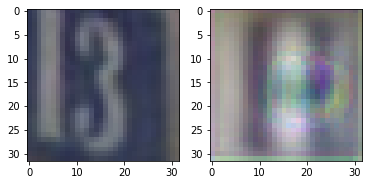

In [9]:
# Feed to neural network 
i = np.random.randint(1,10000)
it = iter(unlabelled_loader)
for n in range(1):
    out = next(it)
    print(out[0].shape)

tst = torch.Tensor(unlabelled_imgs[:,:,:,i]).permute(2,0,1).unsqueeze(0)
out = vae(tst)
out = out[0,:,:,:].permute(1,2,0)
out = out.detach().numpy()
plt.subplot(1,2,1)
plt.imshow(unlabelled_imgs[:,:,:,i])
plt.subplot(1,2,2)
plt.imshow(out)

**Label clustering**

In [10]:
# Get hidden space 
def sample(mu, log_var):
    std = torch.exp(log_var / 2)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    return p, q, z

unlabelled_loader_no_shuffle = DataLoader(unlabelled_data, batch_size=64, shuffle=False)
out_mat_z, out_mu, out_var, label_mat = np.empty((1,256)), np.empty((1,256)), np.empty((1,256)), np.empty(1)
out_x = np.empty((1,512))
for img, label in tqdm(unlabelled_loader_no_shuffle):
    x = vae.encoder(img)
    mu = vae.fc_mu(x)
    log_var = vae.fc_var(x)
    p, q, z = sample(mu, log_var)
    out_x = np.concatenate((out_x, x.detach().numpy()), axis=0)
    out_mat_z = np.concatenate((out_mat_z, z.detach().numpy()), axis=0)
    out_mu = np.concatenate((out_mu, mu.detach().numpy()), axis=0)
    out_var = np.concatenate((out_var, log_var.detach().numpy()), axis=0)
    label_mat = np.concatenate((label_mat, label.detach().numpy()), axis=0)
  

100%|██████████| 1145/1145 [12:09<00:00,  1.57it/s]


In [11]:
from sklearn.cluster import KMeans
r = np.random.RandomState(seed=1234)
km = KMeans(n_clusters=10, random_state=r)  
km.fit(out_x)
pred = km.predict(out_x)

/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:372: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:648: RuntimeWarning: overflow encountered in square
  lloyd_iter(
/tmp/ipykernel_29740/356065990.py:4: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  km.fit(out_x)


In [19]:
np.unique(pred)

array([2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:621: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S**2) / (n_samples - 1)
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:626: RuntimeWarning: overflow encountered in square
  np.square(X, out=X)
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:630: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:634: RuntimeWarning: invalid value encountered in double_scalars
  self.noise_variance_ = total_var - self.explained_variance_.sum()
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as

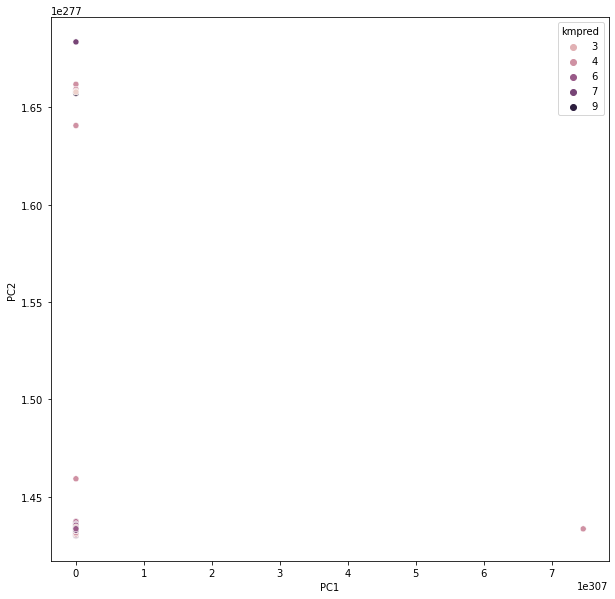

In [20]:
from sklearn.decomposition import PCA
import pandas as pd 
import seaborn as sns

pca = PCA(n_components=10)
out_pca = pca.fit_transform(out_x)
# print("PCA explained variance: {}".format(pca.explained_variance_))

pca_plot = pd.DataFrame({'PC1': out_pca[:,0], 'PC2': out_pca[:,1], 'kmpred': pred})

%matplotlib inline 
plt.subplots(figsize=(10,10))
sns.scatterplot('PC1', 'PC2', hue='kmpred', data=pca_plot)
plt.show()


/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


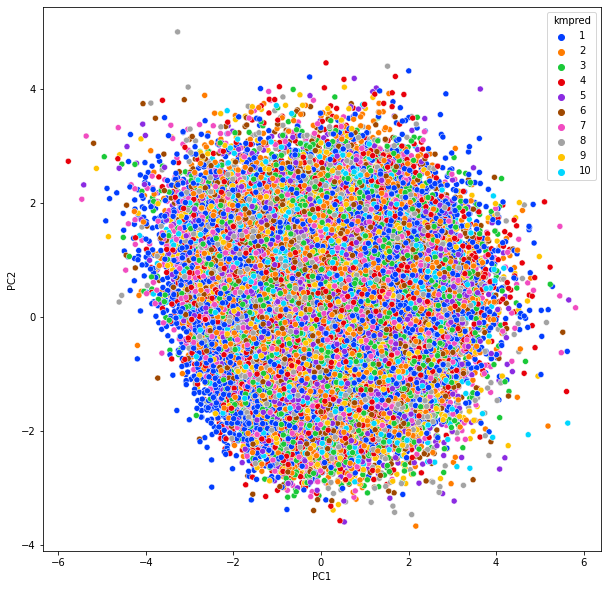

In [38]:
# unlabelled_imgs, unlabelled_labels = load_data('./data','unlabelled_task3')

from sklearn.decomposition import PCA
import pandas as pd 
import seaborn as sns

pca = PCA(n_components=10)
out_pca = pca.fit_transform(out_mu)

pca_plot = pd.DataFrame({'PC1': out_pca[1:,0], 'PC2': out_pca[1:,1], 'kmpred': unlabelled_labels})

%matplotlib inline 
plt.subplots(figsize=(10,10))
sns.scatterplot('PC1', 'PC2', hue='kmpred', data=pca_plot, palette=sns.color_palette("bright"))
plt.show()


Query Image
Retrieved Similar Images


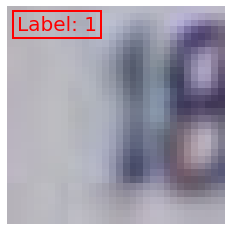

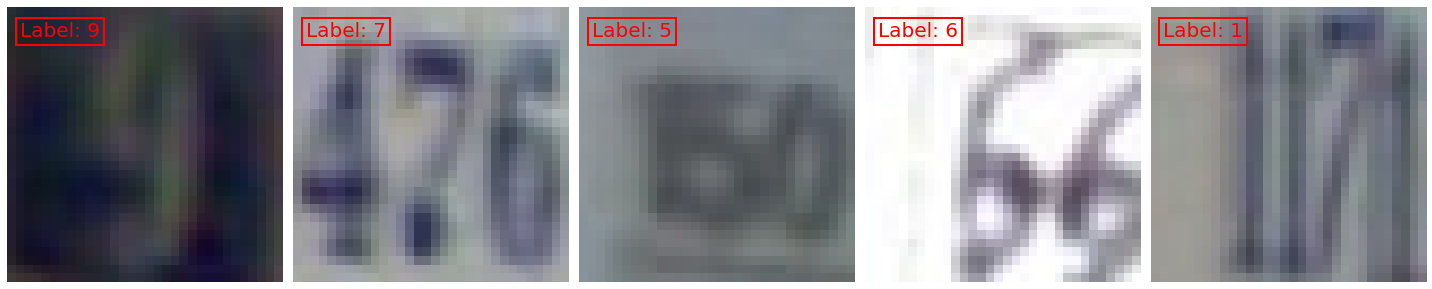

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

i = np.random.randint(0,test_imgs.shape[-1])
img_sample_test = torch.Tensor(test_imgs[:,:,:,i]).permute(2,0,1).unsqueeze(0)
label_sample= torch.Tensor(test_labels[i])

# Pass NN
sample_out = vae.encoder(img_sample_test).detach().numpy()

# Compute Euclidean Distance with training set
dist_train = euclidean_distances(sample_out, out_x).squeeze()

# Parse the K closes distances 
K=5
dist_idx = np.array(dist_train).argsort()[:K]

# Visualize images
print('Query Image')
visualize_image(test_imgs, test_labels, i)
print('Retrieved Similar Images')
# for idx in similar_img_idx:
    
#     visualize_image(unlabelled_imgs, unlabelled_labels,
#                     idx)

plt.subplots(figsize=(20,10))
for i, idx in enumerate(dist_idx):
    plt.subplot(1,5,i+1)
    visualize_image(unlabelled_imgs, unlabelled_labels,
                    idx)
plt.tight_layout()
plt.show()


(32, 32, 3, 50)